# ETF的資料視覺化與EDA
在之前的部分我只對少部分的客戶交易資料做視覺化，現在，則針對ETF分組資料夾裡面的33個`.csv`檔，探討各基金的表現。

同樣地，我先載好中文字體與所需套件。

In [184]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import matplotlib
from random import shuffle

import matplotlib.font_manager as mfm
font_path = "./chinese.simhei.ttf"
prop = mfm.FontProperties(fname = font_path)

由於`csv`檔有很多，我不想一個一個打路徑，於是先用`os.walk`幫我把所有`csv`黨的路徑抓出來。


In [185]:
def get_all_csv_names(src):
    file_list, folder_list = [], []
    for root, d_names, f_names in os.walk(src):
        # print(root, d_names, f_names)
        for i in f_names:
            file_list.append(root + ('' if (root == src) else '/') + i)
        for i in d_names:
            folder_list.append(root + ('' if (root == src) else '/') + i)
    # print(folder_list, '\n', file_list)
    csv_list = []
    for i in file_list:
        if(".csv" in i):
            csv_list.append(i)
    return csv_list

得到一個csv檔的list。

In [186]:
csv_list = get_all_csv_names("ETF")

先打開一個檔案看看裡面有哪些欄目。

In [188]:
df = pd.read_csv(csv_list[0], encoding = "ISO-8859-1")
df.columns.values

array(['Symbol', 'ETF Name', 'Asset Class', 'Total Assets ', 'YTD',
       'Avg Volume', 'Previous Closing Price', '1-Day Change', 'Inverse',
       'Leveraged', '1 Week', '4 Week', '1 year', '3 year', '5 year',
       'YTD FF', '1 Week FF', '4 Week FF', '1 Year FF', '3 Year FF',
       '5 Year FF', 'ETFdb.com Category', 'Inception', 'ER',
       'Commission Free', 'Annual Dividend Rate', 'Dividend Date',
       'Dividend', 'Annual Dividend Yield %', 'P/E Ratio', 'Beta',
       '# of Holdings', '% In Top 10', 'ST Cap Gain Rate',
       'LT Cap Gain Rate', 'Tax Form', 'Lower Bollinger',
       'Upper Bollinger', 'Support 1', 'Resistance 1', 'RSI',
       'Overall Rating', 'Liquidity Rating', 'Expenses Rating',
       'Returns Rating', 'Volatility Rating', 'Dividend Rating',
       'Concentration Rating', 'ESG Score',
       'ESG Score Peer Percentile (%)', 'ESG Score Global Percentile (%)',
       'Carbon Intensity (Tons of CO2e / $M Sales)',
       'SRI Exclusion Criteria (%)', 'Sustai

## 問題一：創立較久的ETF一定表現比較好嗎？
通常都說老字號比較有保障，這對ETF來說也是如此嗎？<br/>
要回答這個問題，我們需要有獲利的指標，在這裡我選擇YTD rate，它代表著近一個會計年的增值與returns狀況。<br/>
接下來，就只需要寫for 迴圈去遍歷剛剛的csv檔們，將裡面的年份與ytd數據抓出來。<br/>
因為格式的關係，要做一些`strip`, `split`, `join`，和例外的判定。<br/>
儲存資料的方式我是用一個dictionary去針對分類名稱存年份的list，另一個dictionary則是存YTD。

In [189]:
year_list_dict = dict()
ytd_list_dict = dict()
for filename in csv_list:
    df = pd.read_csv(filename, encoding = "ISO-8859-1")

    for i in range(len(df["Inception"])):
        asset_class = df["Asset Class"][i]
        if(asset_class not in year_list_dict.keys()):
            year_list_dict[asset_class] = []
        if(asset_class not in ytd_list_dict.keys()):
            ytd_list_dict[asset_class] = []
        year = str(df["Inception"][i]).split("-")
        if(len(year) == 1):
            year = ''.join(year)
            year = year.split("/")
        for j in year:
            if len(j) == 4:
                year = j
                break
        year = int(year)
       
        
        ytd = df["YTD"][i]
        if(not isinstance(ytd, str)):
            continue
        for token in ["%"]:
            ytd = ytd.split(token)
            ytd = ''.join(ytd)
        
        year_list_dict[asset_class].append(year)
        ytd_list_dict[asset_class].append(float(ytd))
# print(year_list_dict, ytd_list_dict)

然後從所畫的圖可以發現，雖然較早的ETF不一定YTD比較高，但相對的波動幅度卻比較小。

Text(0.5, 1.0, 'ETF創歷年份與近期獲利散步圖')

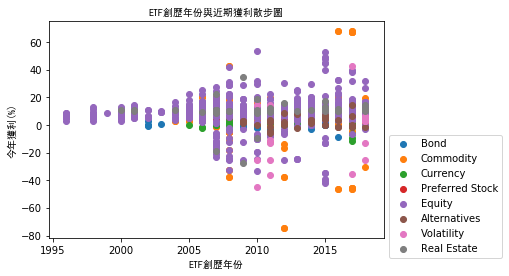

In [210]:
for i in list(year_list_dict.keys()):
    plt.scatter(year_list_dict[i], ytd_list_dict[i], label = i)
plt.legend(bbox_to_anchor=(1,0.5))
plt.ylabel("今年獲利(%)", fontproperties = prop)
plt.xlabel("ETF創歷年份", fontproperties = prop)
plt.title("ETF創歷年份與近期獲利散步圖", fontproperties = prop)

## 問題二：交易最頻繁的ETF是什麼？
我一直想說基金的交易應該會時常在市場上操作所以才提出這個問題，讓我對交易量有些瞭解。<br/>
這跟上一個code很像，總之，我們先把需要的平均交易量針對ETF種類加總，再除以相對應的ETF總數，就可以得出來了。</br>
因為格式的關係，仍然要做一些`strip`, `split`, `join`，和例外的判定。<br/>
儲存資料的方式我是用一個dictionary去針對分類名稱存交易量，另一個dictionary則是存總數。
最後相除，並且排序。

In [218]:
sum_dict = dict()
n_dict = dict()
attribute = "Avg Volume"
for filename in csv_list:
    df = pd.read_csv(filename, encoding = "ISO-8859-1")

    for i in range(len(df[attribute])):
        asset_class = df["Asset Class"][i]
        if(asset_class not in sum_dict.keys()):
            sum_dict[asset_class] = 0
            n_dict[asset_class] = 0
        temp = str(df[attribute][i])
        for token in [",", "$", "US"]:
            temp = temp.split(token)
            temp = ''.join(temp)
        temp = str(temp).split(".")[0]
        if(temp == "nan"):
            continue
        sum_dict[asset_class] += int(temp)
        n_dict[asset_class] += 1
for i in list(sum_dict.keys()):
    sum_dict[i] /= n_dict[i]
sum_dict = dict(sorted(sum_dict.items(), key = lambda x:x[1], reverse = True))
print(sum_dict)

{'Commodity': 1768792.4121621621, 'Volatility': 1647533.2222222222, 'Equity': 1147428.7212978369, 'Preferred Stock': 821541.1666666666, 'Real Estate': 630490.9787234042, 'Bond': 581881.7056603774, 'Currency': 50133.666666666664, 'Alternatives': 32482.02857142857}


以圓餅圖視之。<br/>
每日交易量的最大宗是commodity與volatility。

/usr/local/lib/python3.7/site-packages/matplotlib/legend.py:493: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


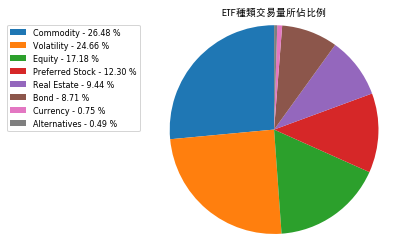

In [219]:
x = np.char.array(list(sum_dict.keys()))
y = np.array(list(sum_dict.values()))

# colors = ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title("ETF種類交易量所佔比例", fontproperties = prop)
plt.savefig('piechart.png', bbox_inches='tight')

## 問題三：什麼種類的ETF會掌管比較大的資產？
這還是跟上一個code很像，總之，我們先把需要的資產總額針對ETF種類加總，再除以相對應的ETF總數，就可以得出來了。<br/>
因為格式的關係，仍然要做一些`strip`, `split`, `join`，和例外的判定。<br/>
儲存資料的方式我是用一個dictionary去針對分類名稱存資產總額，另一個dictionary則是存總數。<br/>
最後相除，並且排序。

In [232]:
sum_dict = dict()
n_dict = dict()
attribute = "Total Assets "
for filename in csv_list:
    df = pd.read_csv(filename, encoding = "ISO-8859-1")

    for i in range(len(df[attribute])):
        asset_class = df["Asset Class"][i]
        if(asset_class not in sum_dict.keys()):
            sum_dict[asset_class] = 0
            n_dict[asset_class] = 0
        temp = str(df[attribute][i])
        for token in [",", "$", "US"]:
            temp = temp.split(token)
            temp = ''.join(temp)
        temp = str(temp).split(".")[0]
        if(temp == "nan"):
            continue
        sum_dict[asset_class] += int(temp) / (10 ** 9)
        n_dict[asset_class] += 1
for i in list(sum_dict.keys()):
    sum_dict[i] /= n_dict[i]
sum_dict = dict(sorted(sum_dict.items(), key = lambda x:x[1], reverse = True))
print(sum_dict)

{'Preferred Stock': 2.0647907374166663, 'Bond': 1.8483782737311827, 'Real Estate': 1.3655938628958335, 'Equity': 1.223446368801606, 'Commodity': 0.7548217183902439, 'Volatility': 0.11344789355555555, 'Alternatives': 0.09682689454285714, 'Currency': 0.057842278138888856}


In [ ]:
圖的結果如下，會發現前五ㄇ

Text(0.5, 1.0, 'ETF種類與資產比較圖')

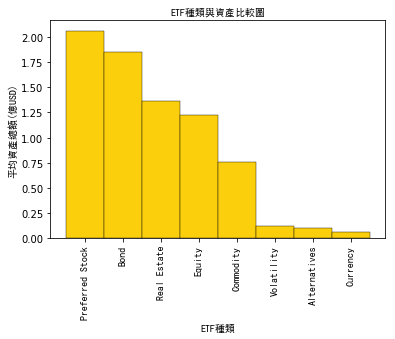

In [229]:
plt.xticks(range(len(list(sum_dict.keys()))), list(sum_dict.keys()), fontproperties = prop, rotation = 90)
plt.bar(range(len(list(sum_dict.values()))), 
        list(sum_dict.values()), 
        color = '#fccf0d', 
        edgecolor='#000000', 
        width=1.0, lw=0.4)
plt.ylabel("平均資產總額(億USD)", fontproperties = prop)
plt.xlabel("ETF種類", fontproperties = prop)
plt.title("ETF種類與資產比較圖", fontproperties = prop)